# Imports

In [26]:
import pandas as pd
from pandas.api.types import is_string_dtype

import numpy as np
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.decomposition import PCA

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error

# Loading Data

In [2]:
with open("sample_dataset.csv") as file:
        bestand = pd.read_csv(file,sep=",")

# format the headers
bestand.columns = bestand.iloc[0]
bestand = bestand.drop(bestand.index[0])

# Convert columns to floats
headers_to_float = bestand.columns[2:]
bestand[headers_to_float] = bestand[headers_to_float].astype(float)

# change ref system to categorical var
bestand["SYSTEM"] = pd.factorize(bestand['SYSTEM'])[0]
bestand["SITE"] = pd.factorize(bestand['SITE'])[0]

# Split and Scale Data

In [19]:
# The target variable
target = "Organic Carbon"

# Scale all numeric variables
bestand_numbers = bestand.iloc[:,3:]
bestand_numbers_values = StandardScaler().fit_transform(bestand_numbers.values)
bestand.iloc[:,3:] = bestand_numbers_values

# Categories and explanatory vars split
Categories = bestand.iloc[:,:3]
Explanatory_Variables = bestand.iloc[:,3:]

# Move into X,y
X = Explanatory_Variables.drop(target, axis=1)
y = Explanatory_Variables[target]

# Train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Feature Selection

## PCA

Reduce from  (189, 24)  to  (189, 9) variables while retaining 90% variance
Explained variance: 0.9103485787743307


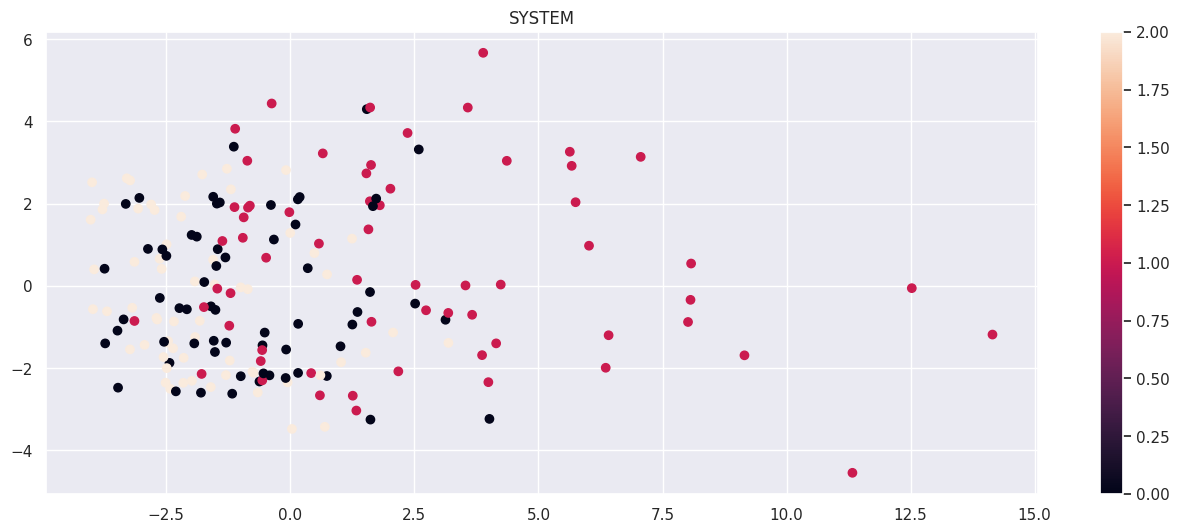

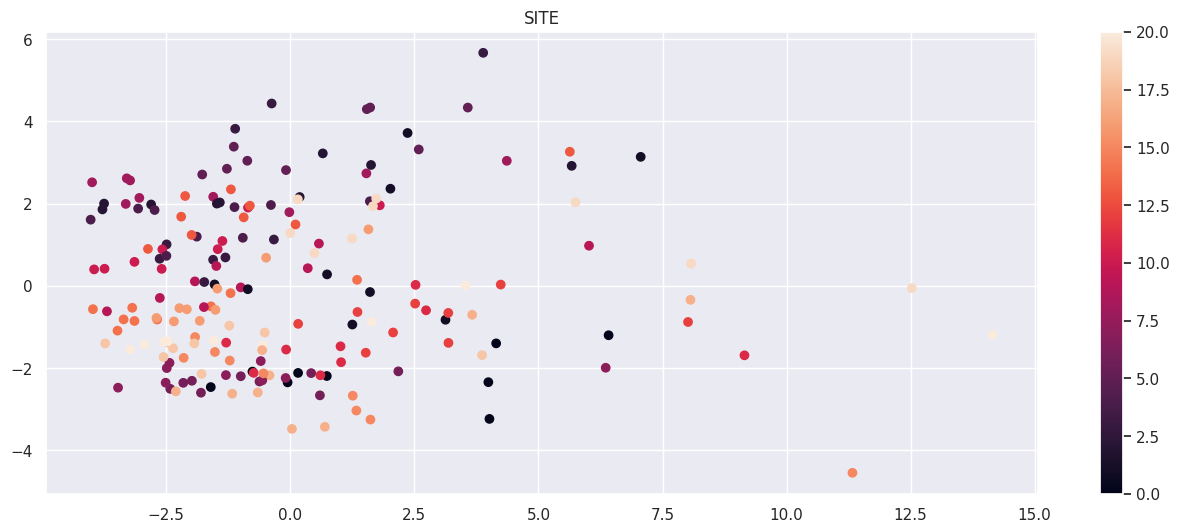

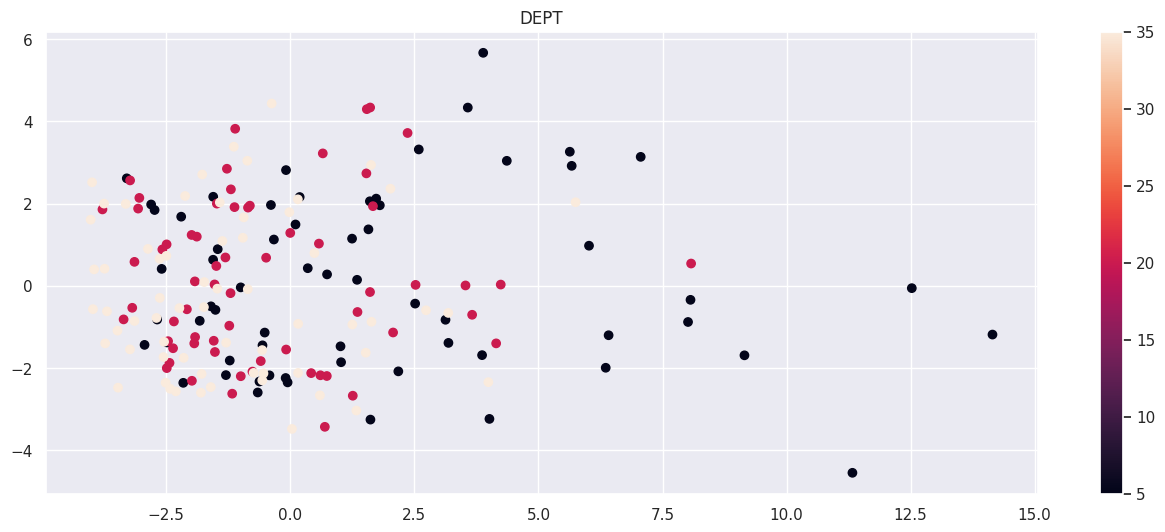

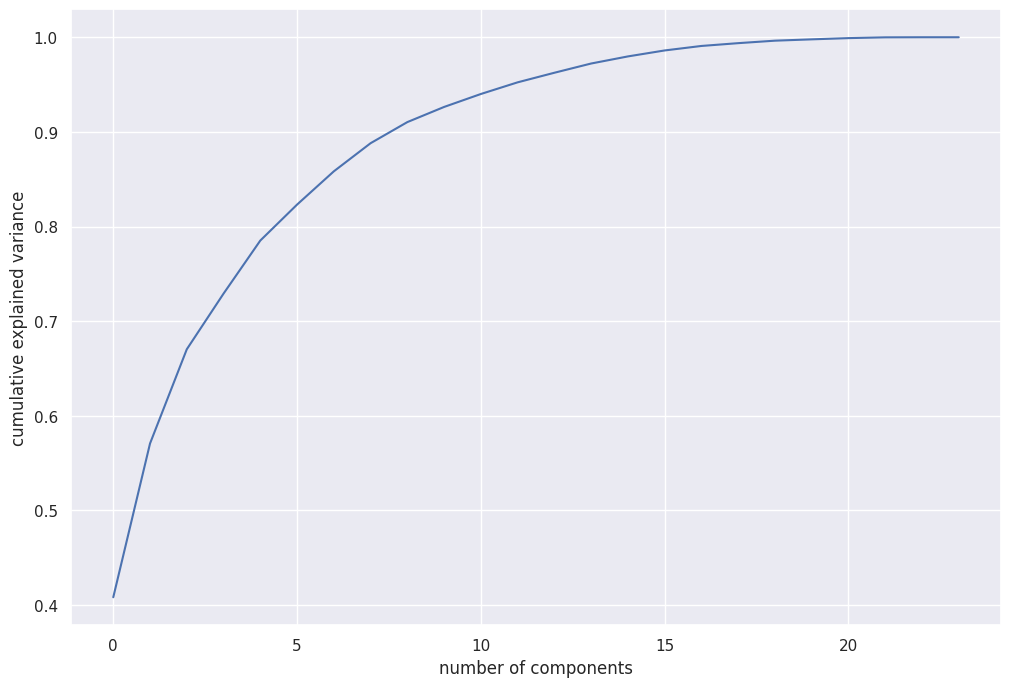

Meaning of the 2 components:
0.04 x Clay + -0.02 x Silt + -0.00 x Sand + 0.07 x pH + 0.17 x Aggregate Stability + -0.16 x Bulk Density + 0.18 x Corg_Clay + 0.25 x Dissolved Org. Carbon + 0.21 x Carbon-to-Nitrogen + -0.11 x Ergosterol + 0.26 x Microbial Carbon + 0.27 x Microbial Nitrogren + 0.25 x Microbial Phosphorus + 0.10 x Manosamine + 0.18 x Muramic Acid + 0.28 x Glucosamine + 0.27 x Sum Aminosugars + 0.28 x LAP + 0.25 x NAG + 0.22 x GLU + 0.23 x XYL + 0.24 x CEL + 0.24 x PHO 

-0.29 x Clay + -0.37 x Silt + 0.43 x Sand + -0.33 x pH + 0.28 x Aggregate Stability + -0.08 x Bulk Density + 0.35 x Corg_Clay + 0.16 x Dissolved Org. Carbon + 0.23 x Carbon-to-Nitrogen + -0.01 x Ergosterol + 0.03 x Microbial Carbon + -0.09 x Microbial Nitrogren + -0.16 x Microbial Phosphorus + -0.01 x Manosamine + 0.01 x Muramic Acid + 0.06 x Glucosamine + 0.01 x Sum Aminosugars + 0.04 x LAP + -0.15 x NAG + -0.05 x GLU + -0.19 x XYL + -0.19 x CEL + -0.18 x PHO 

-0.25 x Clay + -0.11 x Silt + 0.21 x Sand + -0

In [20]:
# Retain90% of variance
pca_soil = PCA(0.9)

# Fit and transform
pca_fit = PCA().fit(Explanatory_Variables)
pca_transform = pca_soil.fit_transform(Explanatory_Variables)
pca_transform_df = pd.DataFrame(pca_transform, index=Explanatory_Variables.index)

# How much info we got
print("Reduce from ",Explanatory_Variables.shape," to ",pca_transform_df.shape, "variables while retaining 90% variance")
print("Explained variance:",np.sum(pca_soil.explained_variance_ratio_))

# Show a scatter plot of the first two components and the respective target variable
for target_var in ["SYSTEM", "SITE", "DEPT"]:
    target_values = Categories[target_var]
    sc = plt.scatter(pca_transform[:,0],pca_transform[:,1], c=target_values)
    plt.colorbar(sc)
    plt.title(target_var)
    plt.show()

# Chart of explained variance
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#Trying to decipher the meaning of the principal components
print("Meaning of the 2 components:")
for component in pca_fit.components_[0:4]:
    print(" + ".join("%.2f x %s" % (value, name)
                     for value, name in zip(component, X_train.columns)),"\n")


# Table of most important components
# get the index of the most important feature on EACH component
n_pcs = pca_soil.components_.shape[0]
most_important = [np.abs(pca_soil.components_[i]).argmax() for i in range(n_pcs)]
most_important_X_train = []
for i in range(len(pca_soil.components_)):
    val = most_important[i]
    most_important_X_train.append(pca_soil.components_[i][val])

# get the names
initial_feature_names = bestand.columns[2:]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
most_important_components_df = pd.DataFrame(dic.items())
most_important_components_df["X_train"] = most_important_X_train
print("Most important components:",most_important_components_df)

## F Regression

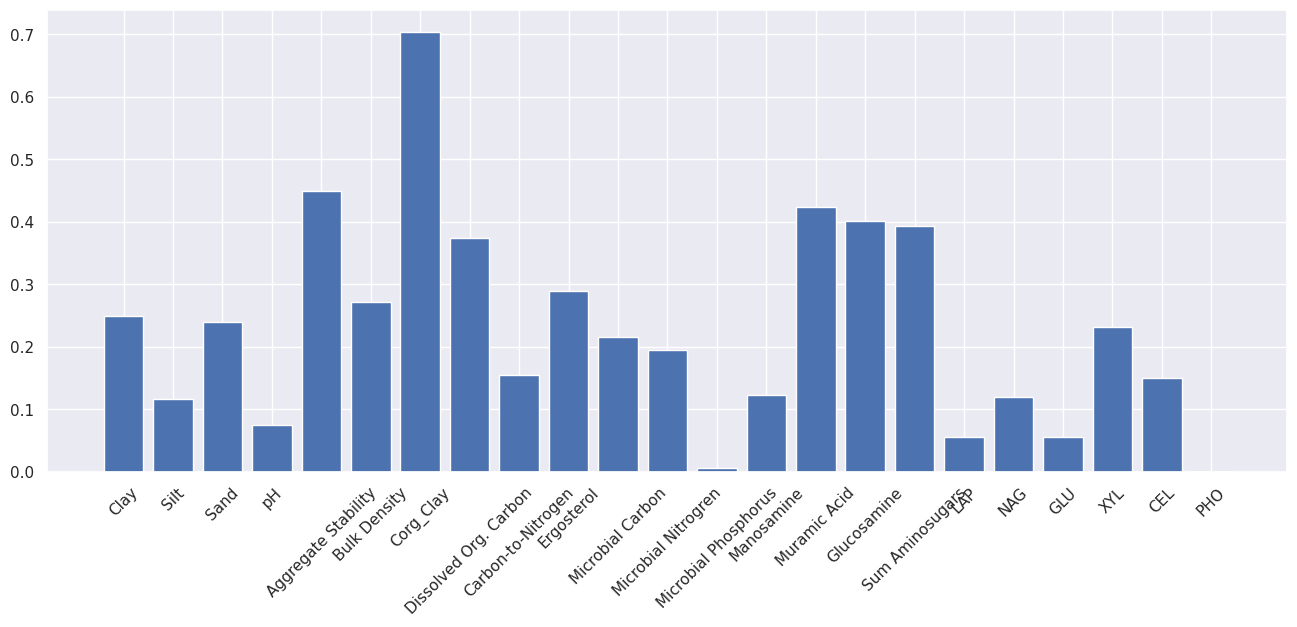

,Clay,Aggregate Stability,Bulk Density,Corg_Clay,Dissolved Org. Carbon,Ergosterol,Microbial Carbon,Muramic Acid,Glucosamine,Sum Aminosugars
1,2.746326,0.549152,-0.243647,-0.827070,0.139548,0.435019,1.354085,1.480324,0.504609,1.095478
2,1.703290,1.231605,-1.048921,-0.347130,1.435819,1.889805,1.749813,2.985442,1.773790,2.436231
3,2.701786,0.467364,0.995236,-0.956606,-0.993718,-0.074618,-0.269388,0.293393,-0.226865,0.082079
4,0.713334,0.257104,0.251906,-0.157783,0.664681,-0.182266,0.631388,1.117399,0.131703,0.615394
5,-1.075529,1.479043,-0.491424,3.752722,2.698259,1.948741,0.952046,2.826601,1.008892,1.870078


In [25]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

sns.set(rc={'figure.figsize':(16,6)})

# configure to select all features
fs = SelectKBest(score_func=mutual_info_regression, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)

plt.bar([X.columns[i] for i in range(len(fs.scores_))], fs.scores_)
plt.xticks(rotation = 45)
plt.show()

# Selekt the k best features
X_fs = SelectKBest(mutual_info_regression, k=10).fit(X,y)
# Get columns to keep and create new dataframe with those only
cols = X_fs.get_support(indices=True)
X_feature_reduced = X.iloc[:,cols]

# Redo the split with reduced x
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_feature_reduced, y, test_size=0.3, random_state=42)

X_feature_reduced.head()

# Machine Learning

## Random Forest All Features

In [36]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

display("Feature Importance: ",pd.DataFrame({'Variable':X.columns,'Importance':model.feature_importances_}).sort_values('Importance', ascending=False))

mse = mean_squared_error(y_test, model.predict(X_test))
mae = mean_absolute_error(y_test, model.predict(X_test))
rmspe = (np.sqrt(np.mean(np.square((y_test - model.predict(X_test)) / y_test)))) * 100

print("\nmse = ",mse,"\nmae = ",mae,"\nrmse = ", sqrt(mse),"\nrmspe = ",rmspe)

'Feature Importance: '

,Variable,Importance
6,Corg_Clay,0.250680
15,Glucosamine,0.243818
4,Aggregate Stability,0.223607
0,Clay,0.050343
7,Dissolved Org. Carbon,0.042330
8,Carbon-to-Nitrogen,0.030507
17,LAP,0.029830
10,Microbial Carbon,0.024344
9,Ergosterol,0.012352
5,Bulk Density,0.012112



mse =  0.15392846070858465 
mae =  0.298336167121905 
rmse =  0.3923371773214777 
rmspe =  207.72598714107596


## Random Forest Selected Features

In [35]:
model = RandomForestRegressor()
model.fit(X_train_reduced, y_train)
y_pred = model.predict(X_test_reduced)

display("Feature Importance: ",pd.DataFrame({'Variable':X_feature_reduced.columns,'Importance':model.feature_importances_}).sort_values('Importance', ascending=False))

mse = mean_squared_error(y_test, model.predict(X_test_reduced))
mae = mean_absolute_error(y_test, model.predict(X_test_reduced))
rmspe = (np.sqrt(np.mean(np.square((y_test - model.predict(X_test_reduced)) / y_test)))) * 100

print("\nmse = ",mse,"\nmae = ",mae,"\nrmse = ", sqrt(mse),"\nrmspe = ",rmspe)

'Feature Importance: '

,Variable,Importance
3,Corg_Clay,0.279230
8,Glucosamine,0.249047
1,Aggregate Stability,0.221826
0,Clay,0.074327
6,Microbial Carbon,0.050648
4,Dissolved Org. Carbon,0.044976
5,Ergosterol,0.026482
2,Bulk Density,0.021859
7,Muramic Acid,0.020153
9,Sum Aminosugars,0.011452



mse =  0.1240574246855111 
mae =  0.259564037178724 
rmse =  0.35221786536959065 
rmspe =  163.8359660931756


In [43]:
import lime
import lime.lime_tabular
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=[target], verbose=True, mode='regression')

def plot_explain(i):
    exp = explainer.explain_instance(X_test.iloc[int(i)], model.predict, num_features=5)
    fig = exp.as_pyplot_figure()
    fig.show()

%matplotlib inline

import numpy as np

interact(plot_explain, i = widgets.FloatSlider(value=1, min=1, max=10, step=1))


interactive(children=(FloatSlider(value=1.0, description='i', max=10.0, min=1.0, step=1.0), Output()), _dom_cl…

<function __main__.plot_explain(i)>